# Projektpraktikum Data Mining Cup - Random Forest 
#### Dominik Lewin, Mario Teßmann, Johannes Winkler

Nach dem Trainieren diverser Algorithmen stellte sich zunächst heraus, dass der Random Forest vielversprechende Ergebnisse liefert. In diesem Jupyter Notebook wird es darum gehen, das Modell zu optimieren, nicht benötigte Attribute zu entfernen und die Parameter des Modells anzupassen. Dafür wird der während der vorausgehenden Phase entwickelte aufbereitete Datensatz verwendet. 


# Inhaltsverzeichnis

* [1. Verwendete Funktionen](#funktionen)
* [2. Random Forest auf dem aufbereiteten Datensatz](#aufbereitet)
* [3. Verwerfen unwichtiger Attribute](#most)
* [4. Gittersuche](#gitter)
* [5. Umgang mit unbalancierten Daten](#void)
* [6. Fazit](#fazit)

## 1. Verwendete Funktionen <a class="anchor" id="funktionen"></a>

Um das Trainieren der Modelle und die Ausgabe vergleichbarer Ergebnisse zu vereinfachen, werden einige Funktionen erstellt. Diese erstellen auf dem jeweiligen Datensatz immer einen reproduzierbaren Trainings- und Testdatensatz, trainiert anschließend das Modell auf den Trainingsdaten und gibt schließlich umfangreiche Ergebnisse des Testdatensatzes aus. Dazu gehören:
- Ergebnisse der Kreuzvalidierung
- Die Konfusionsmatrix
- Der Gewinn bzw. Verlust nach vorgegebener Kostenfunktion
- Feature Importances

Die verwendete Kostenfunktion wurde von der Auftraggeberin vorgegeben und enthält folgende Bedingungen:
- Für korrekt erkannte fehlerhafte Einkäufe (true-positive): +5 Euro
- Für nicht erkannte fehlerhafte Einkäufe (false-negative): -5 Euro
- Für korrekte Einkäufe, die als fehlerhaft klassifiziert werden (false-positive): -25 Euro

Somit lautet die Gewinnfunktion:

>$Gewinn = TP * 5 - FP * 25 - FN * 5$

In [1]:
#Pakete importieren
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
#Globale Variablen
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [3]:
# Eigene Gewinnfunktion für Kreuzvalidierung definieren
def score_function(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    tp = conf_matrix[1, 1]
    fp = conf_matrix[0, 1]
    fn = conf_matrix[1, 0]
    score = tp * 5 - fp * 25 - fn * 5
    return score

# Scorer erstellen
custom_scorer = make_scorer(score_function, greater_is_better=True)

In [4]:
#Datensatz zufällig in Trainings- und Testdaten splitten
def get_train_test(df):
    X = df.drop(["label"], axis=1)
    y = df["label"]
    
    #Erzeuge Trainings- und Testdaten
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    return X_train, X_test, y_train, y_test

In [5]:
#Ergebnisse des Modells ausgeben
def result(model, X_test, y_test):
    # Vorhersagen für Testdaten machen
    y_pred = model.predict(X_test)

    # Konfusionsmatrix erstellen
    conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)
    score = conf_matrix[1,1]*5 - conf_matrix[0,1]*25 - conf_matrix[1,0]*5
    print()
    print("Gewinn: ", score)
    
    print()
    print("Konfusionsmatrix:")
    print(conf_matrix)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=model.classes_)
    disp.plot()
    plt.show()

In [6]:
def importances(X, model):
    # Feature Importances erhalten
    feature_importances = model.feature_importances_

    # Feature-Namen aus dem DataFrame
    feature_names = X.columns

    # Feature Importances mit Feature-Namen zusammenführen und sortieren
    sorted_importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)
        
    # Sortieren der Feature Importances für bessere Lesbarkeit
    features, importances = zip(*sorted_importances)

    # Plotten der Feature Importances mit Werten
    plt.figure(figsize=(10, 6))
    plt.barh(features, importances)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importances des Random Forest')

    # Importance-Werte direkt im Graphen anzeigen
    for index, value in enumerate(importances):
        plt.text(value, index, f'{value:.2f}')

    plt.gca().invert_yaxis()
    plt.show()

In [7]:
def train_test(df, model):
    #Daten splitten
    X_train, X_test, y_train, y_test = get_train_test(df)
    
    #Model trainieren
    model.fit(X_train, y_train)
    
    #Kreuzvalidierung durchführen
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=custom_scorer)
    
    #Ergebnisse ausgeben
    print("Ergebnisse der Kreuzvalidierung:")
    print()
    print("Erreichte Gewinne: ", scores)
    print("Erreichter mittlerer Gewinn ", scores.mean())
    print("Standardabweichung: ", scores.std())
    result(model, X_test, y_test)
    importances(X_train, model)

In [8]:
#Die Funktion bekommt das trainierte Modell, eine Liste von Dictionaries, den Trainingsdatensatz
#ohne Labels und die Trainingslabels übergeben.
#Es werden alle Kombinationen probehalber je 5 mal trainiert, um die beste Kombination von Hyperparametern
#zu erhalten. Die Ergebnisse für jede Kombination wird ausgegeben. Die beste Kombination wird ausgegeben.

def gittersuche(model, param_grid, X_train, y_train, methode=custom_scorer):
    
    grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring=methode,return_train_score=True)
    #Trainiere auf Trainingsdaten
    grid_search.fit(X_train, y_train)
     
    #Gebe die beste Kombination der Hyperparameter aus
    print()
    print("Beste Parameter: ", grid_search.best_params_)
    print("Bester Score: ", grid_search.best_score_)
    return

## 2. Random Forest auf dem aufbereiteten Datensatz <a class="anchor" id="aufbereitet"></a>

Hierfür werden zunächst die Daten eingelesen.

In [32]:
#Einlesen des Datensatzes
df = pd.read_csv("final_df_train.csv", sep=",", index_col=0)

In [10]:
df

,grand_total,n_items,total_checkout_time,line_voids,most_freq_product_alcohol,most_freq_product_bakery,most_freq_product_convenience,most_freq_product_dry,most_freq_product_energy_drink,most_freq_product_fruit and vegetables,...,convenience,bakery,household,energy_drink,weekday,hour,payment_medium_card,payment_medium_cash,cash_desk_id,label
0,63.31,24,324,1,0,0,0,1,0,0,...,3,3,0,0,0,8,1,0,2,0
1,29.59,11,92,0,0,0,0,1,0,0,...,0,0,0,0,0,8,1,0,1,0
2,28.70,12,160,0,0,0,0,1,0,0,...,0,4,0,0,0,8,1,0,3,0
3,37.95,8,120,0,0,0,0,1,0,0,...,1,1,1,0,0,8,1,0,4,0
4,5.26,4,79,2,0,0,0,1,0,0,...,0,1,0,0,0,8,1,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104641,25.29,13,122,1,0,0,0,1,0,0,...,0,2,0,0,0,21,0,1,3,0
104642,3.99,1,31,0,0,0,0,0,0,0,...,0,0,0,0,0,21,0,1,3,0
104643,1.39,1,42,0,0,1,0,0,0,0,...,0,1,0,0,0,21,0,1,1,0
104644,10.06,5,95,0,0,1,0,0,0,0,...,0,3,0,0,0,21,1,0,2,0


Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-1275  -970 -1040 -1085 -1135]
Erreichter mittlerer Gewinn  -1101.0
Standardabweichung:  102.53779790886871

Gewinn:  -1675

Konfusionsmatrix:
[[20005    17]
 [  579   329]]


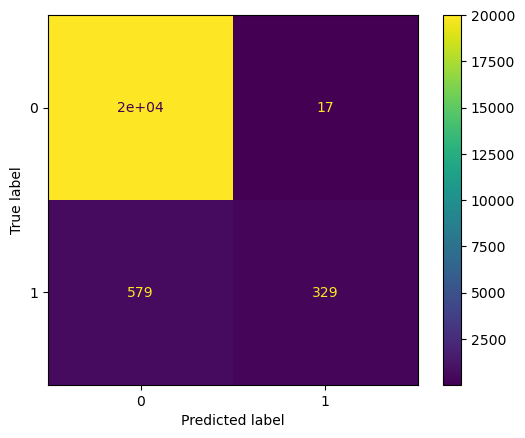

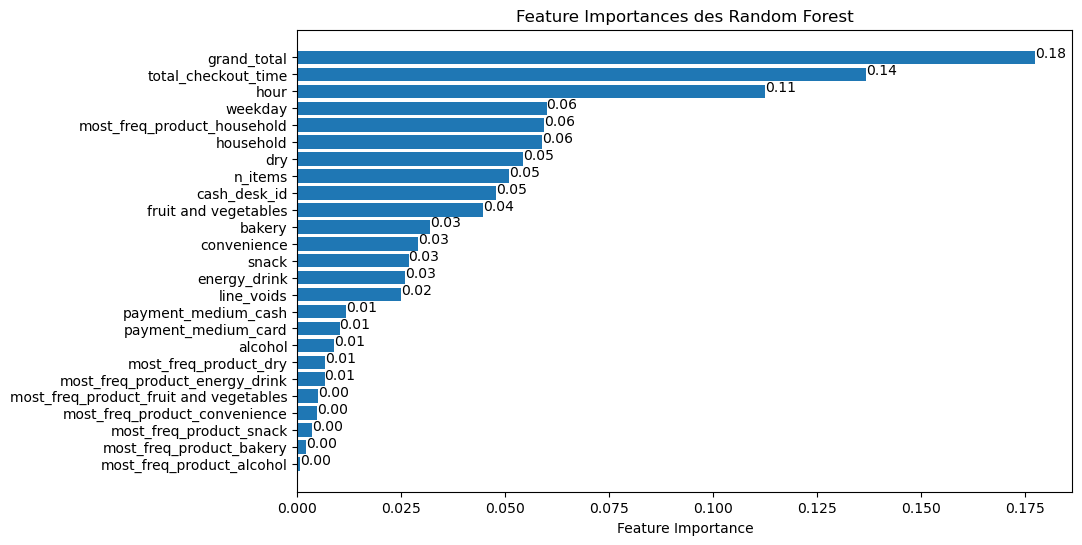

In [11]:
model = RandomForestClassifier()
train_test(df, model)

## 3. Verwerfen unwichtiger Attribute <a class="anchor" id="most"></a>

Wie man soeben gesehen hat, gibt es einige Attribute, die einen sehr geringen Einfluss auf die Klassifikation des Modells haben. Diese Attribute sollen entfernt werden, um zu schauen, ob die Ergebnisse besser werden bzw. sich zumindest nicht verschlechtern. So kann einer Überanpassung an die Trainingsdaten entgegengewirkt werden.

In [33]:
df = df.drop(['most_freq_product_alcohol',
 'most_freq_product_bakery',
 'most_freq_product_convenience',
 'most_freq_product_dry',
 'most_freq_product_energy_drink',
 'most_freq_product_fruit and vegetables',
 'most_freq_product_snack',
 'alcohol',
 'payment_medium_card',
 'payment_medium_cash'], axis=1)

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-1200  -930  -930  -945 -1060]
Erreichter mittlerer Gewinn  -1013.0
Standardabweichung:  105.43244282477761

Gewinn:  -1680

Konfusionsmatrix:
[[20004    18]
 [  577   331]]


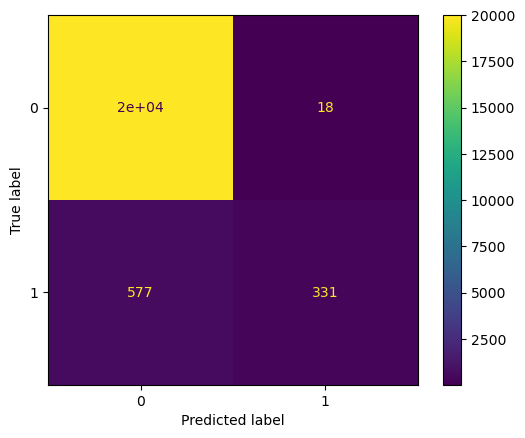

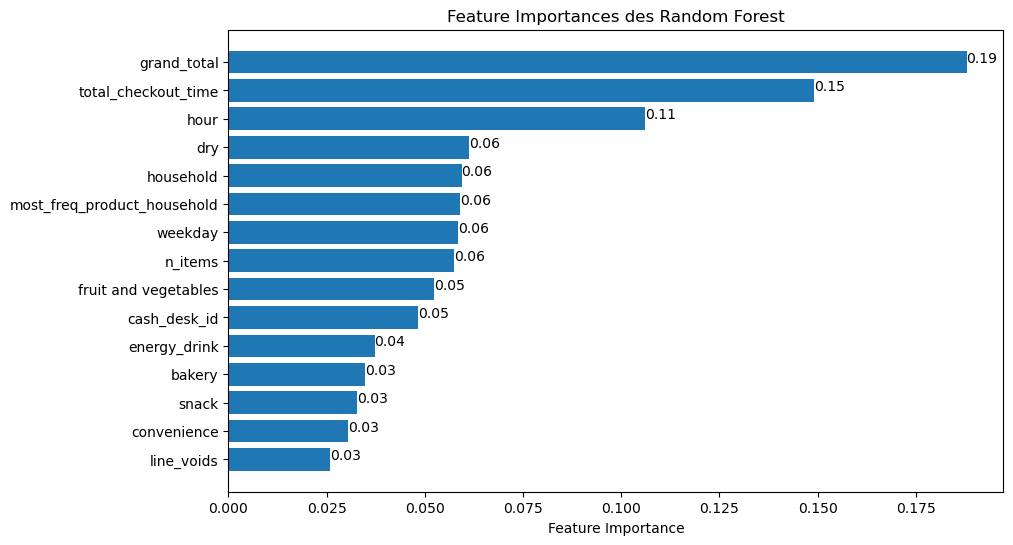

In [13]:
model = RandomForestClassifier()
train_test(df, model)

In diesem Fall sind die Ergebnisse der Kreuzvalidierung sogar etwas besser geworden. Es wird weiter versucht, irrelevante Attribute zu eliminieren.

In [14]:
df_test = df.drop(['line_voids', 'convenience', "snack", "bakery"], axis=1)

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-1360 -1265 -1275 -1065 -1405]
Erreichter mittlerer Gewinn  -1274.0
Standardabweichung:  116.89311356961966

Gewinn:  -1865

Konfusionsmatrix:
[[19999    23]
 [  583   325]]


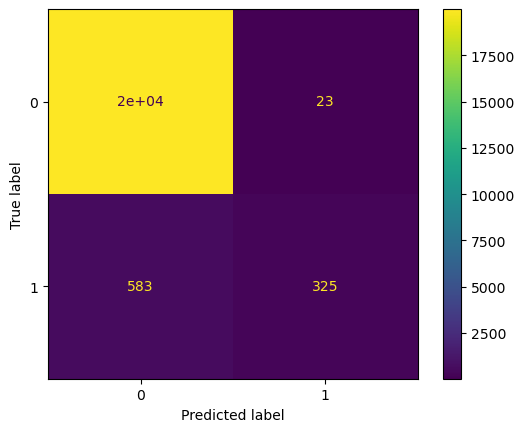

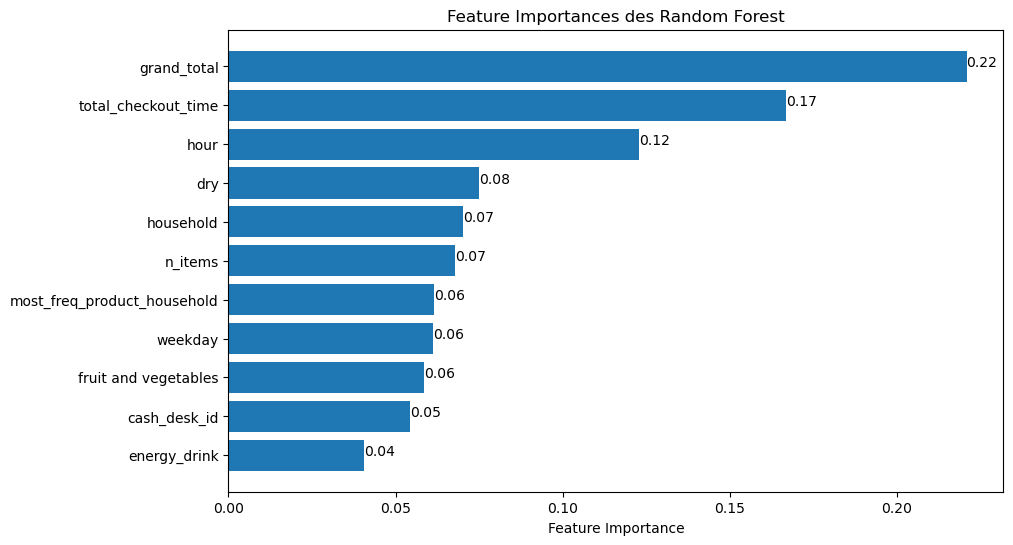

In [15]:
model = RandomForestClassifier()
train_test(df_test, model)

Dies führte zu einer Verschlechterung der Ergebnisse, sowohl auf den Trainingsdaten als auch bei der Kreuzvalidierung, weshalb die letztgenannten Attribut weiter im Datensatz enthalten sein sollten.

## 4. Gittersuche <a class="anchor" id="gitter"></a>

Um die beste Parameterkombination für den Random Forest zu finden, soll an dieser Stelle eine umfangreiche Gittersuche durchgeführt werden. Dafür werden insgesamt sechs Parameter angepasst, die vermutlich Einfluss auf die Ergebnisse haben.

In [34]:
#Gittersuche für Random Forest

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt'],
    'bootstrap': [True, False]
}

gittersuche(model, param_grid, df.drop(["label"], axis=1), df["label"])


Beste Parameter:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Bester Score:  -1205.0


Es wurde nun die beste Parameterkombination ausgegeben. Diese soll nun angewendet und getestet werden.

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-1050  -805  -970  -905 -1020]
Erreichter mittlerer Gewinn  -950.0
Standardabweichung:  87.57853618324526

Gewinn:  -1390

Konfusionsmatrix:
[[20018     4]
 [  583   325]]


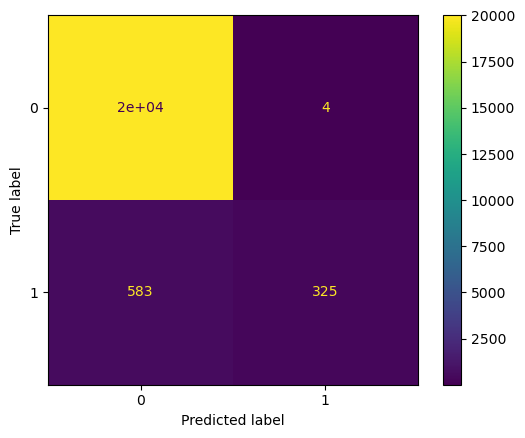

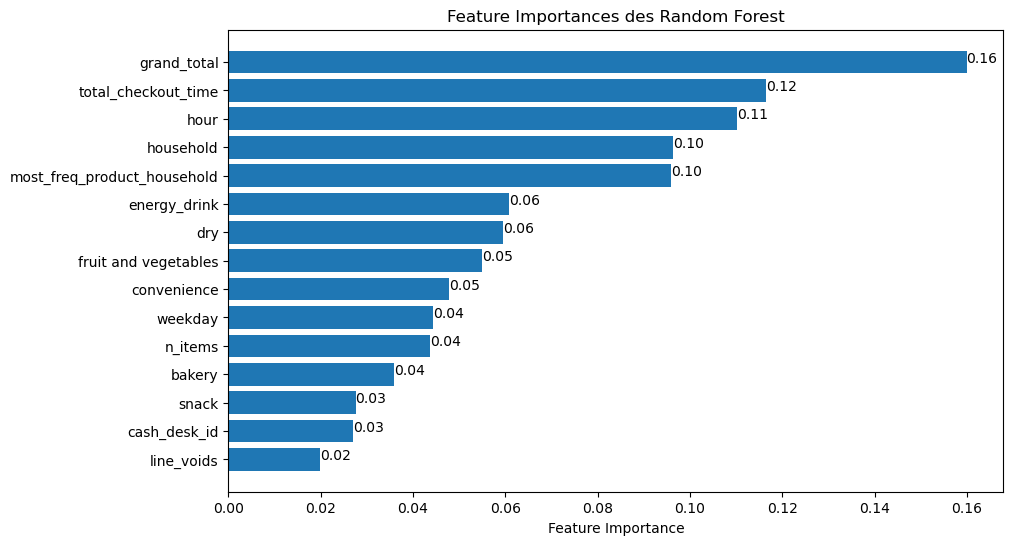

In [17]:
model = RandomForestClassifier(n_estimators=200, bootstrap=True, max_depth=20, max_features="sqrt", 
                             min_samples_leaf=1, min_samples_split=10)
train_test(df, model)

## 5. Umgang mit unbalancierten Daten <a class="anchor" id="void"></a>

Da der Datensatz unbalanciert ist, sollen an dieser Stelle einige Methoden ausprobiert werden, um diese Problematik beim Training zu berücksichtigen. Dazu gehört zum einen der Parameter "class_weight" des Random Forest Classifiers und zum anderen eine Undersampling-Methode, der SMOTE-Algorithmus.

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-2315 -2700 -1740 -2150 -2395]
Erreichter mittlerer Gewinn  -2260.0
Standardabweichung:  315.3886491299267

Gewinn:  -3020

Konfusionsmatrix:
[[19942    80]
 [  556   352]]


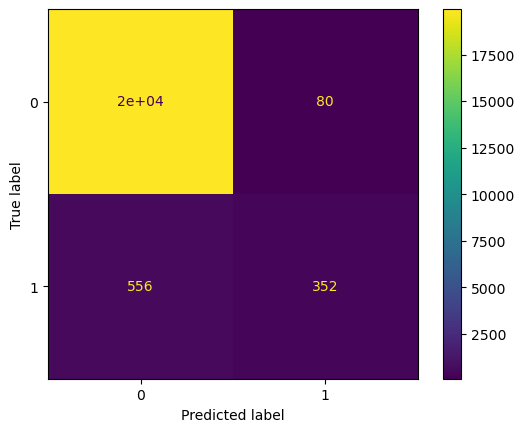

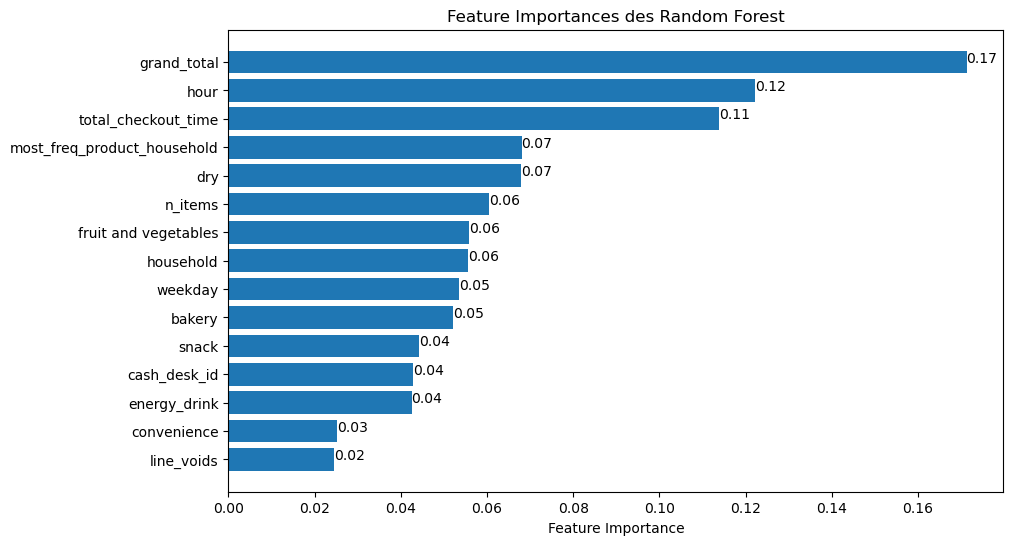

In [18]:
model = RandomForestClassifier(n_estimators=200, bootstrap=True, max_depth=20, max_features="sqrt", 
                             min_samples_leaf=1, min_samples_split=10, class_weight="balanced")
train_test(df, model)

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-2125 -2470 -1900 -2250 -2070]
Erreichter mittlerer Gewinn  -2163.0
Standardabweichung:  190.30501832584446

Gewinn:  -2825

Konfusionsmatrix:
[[19949    73]
 [  554   354]]


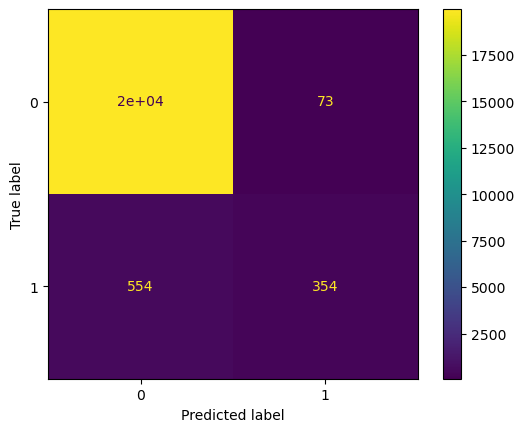

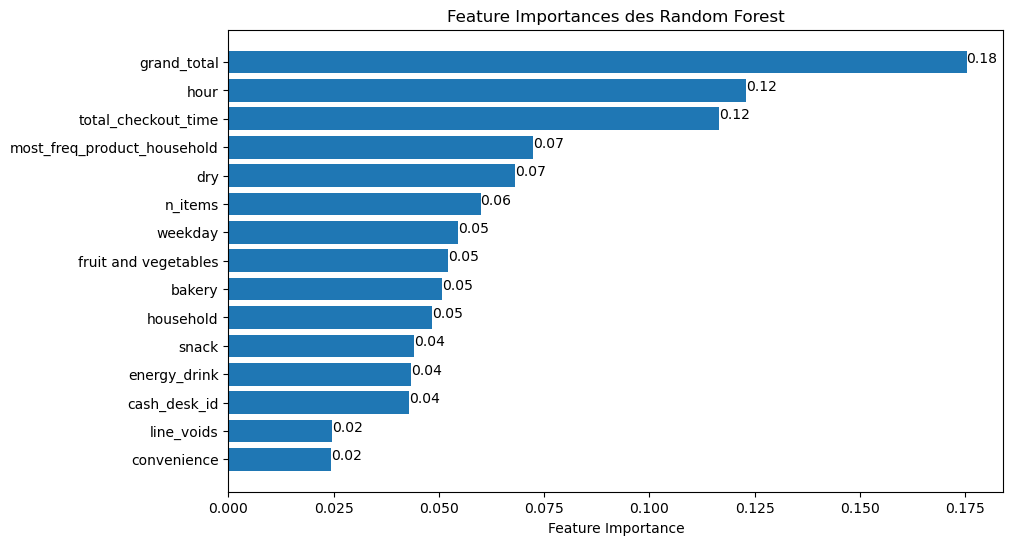

In [19]:
model = RandomForestClassifier(n_estimators=200, bootstrap=True, max_depth=20, max_features="sqrt", 
                             min_samples_leaf=1, min_samples_split=10, class_weight="balanced_subsample")
train_test(df, model)

In [20]:
#Aufteillung in Trainings- und Testdaten für Untersampling-Methoden
def get_train_test_undersampling(df):
    X = df.drop(["label"], axis=1)
    y = df["label"]
    
    #Erzeuge Trainings- und Testdaten
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    
    undersampler = SMOTE(random_state=42)
    X_train, y_train = undersampler.fit_resample(X_train, y_train)
    
    return X_train, X_test, y_train, y_test

In [23]:
#Angepasste Version für Untersampling-Methoden
def train_test_undersampling(df, model):
    #Daten splitten
    X_train, X_test, y_train, y_test = get_train_test_undersampling(df)
    
    #Model trainieren
    model.fit(X_train, y_train)
    
    #Kreuzvalidierung durchführen
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=custom_scorer)
    
    #Ergebnisse ausgeben
    print("Ergebnisse der Kreuzvalidierung:")
    print()
    print("Erreichte Gewinne: ", scores)
    print("Erreichter mittlerer Gewinn ", scores.mean())
    print("Standardabweichung: ", scores.std())
    result(model, X_test, y_test)
    importances(X_train, model)

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [51820 52790 53835 52655 52970]
Erreichter mittlerer Gewinn  52814.0
Standardabweichung:  645.0844905901862

Gewinn:  -24555

Konfusionsmatrix:
[[19049   973]
 [  477   431]]


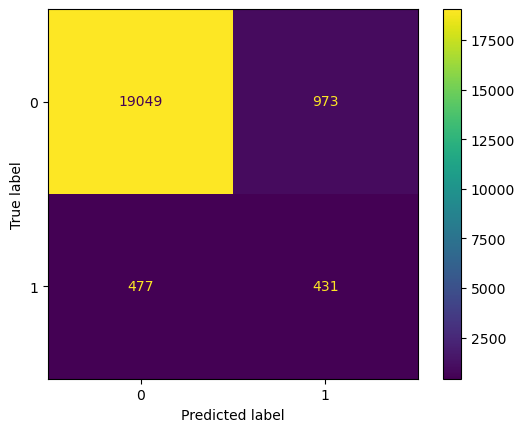

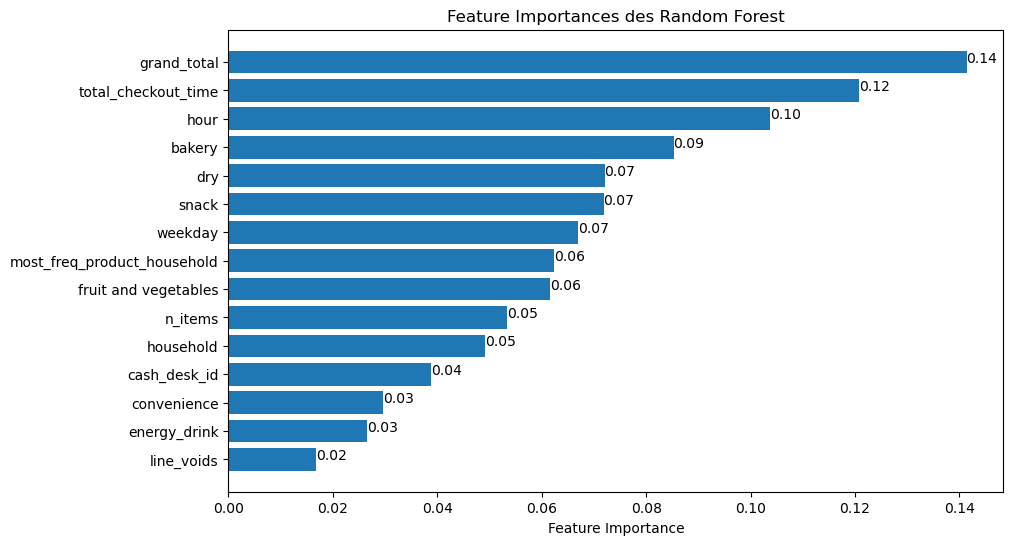

In [24]:
model = RandomForestClassifier(n_estimators=200, bootstrap=True, max_depth=20, max_features="sqrt", 
                             min_samples_leaf=1, min_samples_split=10)
train_test_undersampling(df, model)

## 6. Fazit <a class="anchor" id="fazit"></a>

Alle Versuche, den Datensatz auszubalancieren, haben nicht funktioniert. Die Ergebnisse wurden lediglich drastisch verschlechtert. Auch das Hinzufügen neuer Attribute (was in diesem Notebook zur besseren Übersicht nicht gezeigt wurde), brachten keine Verbesserungen. 

Das beste Ergebnis lieferte in diesem Fall ein reduzierter Datensatz mit Hilfe der durch eine Gittersuche bestimmten Parameterkombination. Das beste Ergebnis ist in Abschnitt 4 zu finden.

Da erste Tests mit Boosting-Algorithmen bessere Ergebnisse lieferten, werden diese in einem separaten Notebook umfangreich behandelt.